## CG

In [1]:
import numpy as np
from numpy.linalg import norm

def cg(Q, b, x, tol=1e-9, max_it = 30000, callback=None):    
    """Conjugate gradient algorithm
    
    Solves the problem 
    min xQx/2. + xb
    
    Parameters:
        Q: ndarray, positive definite, symmetric matrix Q
        b: ndarray, negative right side
        x: ndarray, start value
        tol: [float], gradient norm tolerance
        maxit: [int], maximum number of iterations
        callback: [callable], Callback function
    Returns:
        ndarray, solution
    """
    n = b.size    
    beta = 0
    p = np.zeros(n)
    r = Q@x + b
    res_new  = norm(r)
    k=0   
    while res_new >= tol and k < max_it:
        k+=1
        p = -r + beta*p
        alpha = res_new**2 / p.dot(Q@p)
        if not callback is None:
            callback(x)
        x = x + alpha*p
        r = r + alpha*(Q@p)
        res_old = res_new
        res_new = norm(r)
        beta = res_new**2/res_old**2
    if not callback is None:
        callback(x)
    if k==max_it:
        print("Algorithm reached max iterations!")
    return  x

In [2]:
from cg_test import CallBack

print("\nTest cg on xQx+b.")
Q = np.array([[1, 2], [2, 10]])/2
print("Matrix Q\n\n", Q)
b = np.array([1.,1.])
print("\nRight hand side b\n", -b)
x0 = np.array([0.,0.])

def fQ(x):
    return x@Q@x/2 +b@x

callback=CallBack()
sol_cg = cg(Q,b,x0,callback=callback)

print("Iterations: ", callback.getxk().shape[0]-1)
print("Iterates:\n", callback.getxk())
print("\nTest:\nQx =", Q@sol_cg)
callback.plot(lambda x: x@Q@x/2 + b@x, xmin=-4, xmax=2.)


Test cg on xQx+b.
Matrix Q

 [[0.5 1. ]
 [1.  5. ]]

Right hand side b
 [-1. -1.]
Iterations:  2
Iterates:
 [[ 0.          0.        ]
 [-0.26666667 -0.26666667]
 [-2.66666667  0.33333333]]

Test:
Qx = [-1. -1.]


<Figure size 640x480 with 1 Axes>

### Solving singular systems

Use the CG-implementation in \verb|numopt_version03.ipynb| to solve the problem
$$
    \min \limits_{x} x^\top Q x + x^Tb,
$$ 
where 
\begin{align*}
    \begin{pmatrix}
        1  			& -1 	&   0  	& 0   		& 0			&\dots	\\
        -1 			&  2 	&  -1 	& 0 		&  0 		&\dots	\\
        0  			&  -1	&   2 	& -1      	& 0			& \dots	\\
                    &  		&\ddots & \ddots  	& \ddots    &	\\
                    &\dots	&	0	&   -1		&   2		& -1		\\
                    &\dots & 	0	&   0    	& -1		& 1
    \end{pmatrix}
    \in \mathbb{R}^{50000 \times 50000}
\end{align*}
and $b = (1, -1, 1, -1, \dots) \in \mathbb{R}^{50000}$. 
    
**Note $Q$ is a singular matrix, however 
$b \in $ Im$(Q)$!**
    
 It is possible to set up a linear operator class which can be used together with Python's @-Operator.

In [3]:
import scipy.sparse.linalg as sp

class neumann_type_matproduct:
    def __init__(self, size):
        self.shape = (size, size) 
        
    def matvec(self, x):
        n = self.shape[0]           
        u_right = np.zeros(n, dtype=np.float)
        u_left = np.zeros(n, dtype=np.float)
        u_center = np.zeros(n, dtype=np.float)

        u_right[:-1] = -x[1:]
        u_left[1:] = -x[:-1]
        u_center[1:-1] = 2*x[1:-1]
        u_center[0] = x[0]
        u_center[-1] = x[-1]
        
        return u_left + u_center + u_right

size = 50000

# Set up matrix opbject which can be used with the @-operator
# the row sums of Q are 0, so the system has a non-trivial kernel!
Q = sp.aslinearoperator(neumann_type_matproduct(size))

# Right hand side with mean 0
b = np.ones(size)
b[1::2] = -1
print("The mean of b is: ", np.mean(b))

# Starting value for the cg 0
x0 = np.zeros(size)

callback=CallBack()
sol_cg = cg(Q,b,x0,callback=callback)

print("Iterations: ", callback.getxk().shape[0]-1)
print("\nTest:\nQx =", np.linalg.norm(Q@sol_cg + b))

The mean of b is:  0.0
Iterations:  25001

Test:
Qx = 1.3798086624340779e-08


The problem can be solved without any effort, because the right hand side $b \in$Im$(Q)$ so that the residuals are always in the Krylov-Subspace. This is all we need. So the CG-method can find the solution for consistent (i.e. solvable) problems even if the system matrix $Q$ is singular! 

## Jacobi preconditioned CG

In [4]:
import time 

for n in [10, 50, 250, 1250]:
    #print(scale)
    #Q = np.eye(n)*scale# + 2*np.eye(n, k=1)*scale
    
    Q = np.diag(np.arange(1,n+1))
    #Q = 2* np.eye(n)/(n-1)**2 - 2*np.eye(n, k=1)/(n-1)**2
    #Q = (Q + Q.T)/2.

    #print(Q)

    b = np.ones(n)
    x0 = b
    print("\nn =",n,"----------------------------")
    # Condition number
    print("Condition number of Q\t {0:1.2e}".format(np.linalg.cond(Q)))
    callback=CallBack()
    start = time.time()
    sol_cg = cg(Q,b,x0,callback=callback)
    wct = time.time() - start
    print("Iterations of CG: ", callback.getxk().shape[0]-1)
    print("Wallclock time: ", "{0:1.2e}".format(wct))
    print("")
    
    start = time.time()
    # Preconditioner
    D = np.sqrt(np.diag(1/np.diag(Q))) 
    print("Condition number of DQD\t {0:1.2e}".format(np.linalg.cond(D@Q@D)))
    callback=CallBack()
    sol_cg = cg(D@Q@D, D@b, x0, callback=callback)
    wct = time.time() - start
    print("Iterations of Jacobi PCG: ", callback.getxk().shape[0]-1)
    print("Wallclock time: ", "{0:1.2e}".format(wct))

    #print("\n Solution: ", Q@D@sol_cg)


n = 10 ----------------------------
Condition number of Q	 1.00e+01
Iterations of CG:  10
Wallclock time:  7.25e-02

Condition number of DQD	 1.00e+00
Iterations of Jacobi PCG:  1
Wallclock time:  2.32e-04

n = 50 ----------------------------
Condition number of Q	 5.00e+01
Iterations of CG:  44
Wallclock time:  2.30e-03

Condition number of DQD	 1.00e+00
Iterations of Jacobi PCG:  1
Wallclock time:  4.00e-04

n = 250 ----------------------------
Condition number of Q	 2.50e+02
Iterations of CG:  108
Wallclock time:  2.96e-02

Condition number of DQD	 1.00e+00
Iterations of Jacobi PCG:  1
Wallclock time:  9.40e-03

n = 1250 ----------------------------
Condition number of Q	 1.25e+03
Iterations of CG:  249
Wallclock time:  2.19e+00

Condition number of DQD	 1.00e+00
Iterations of Jacobi PCG:  1
Wallclock time:  6.93e-01


## Nonlinear CG

In [5]:
from scipy.optimize import root_scalar
from cg_test import grad

def nlcg(f, x, tol=1e-9, max_it = 1000, callback=None):
    n = x.size    
    beta = 0
    p = np.zeros(n)
    r=grad(f,x) #r = Q(x) + b # Replace residual by gradient
    res_new  = norm(r)
    k=0   
    while res_new >= tol and k < max_it:
        k+=1
        p = -r + beta*p
        # Replace alpha by linesearch
        #alpha = res_new**2 / p.dot(Q(p))
        alpha = root_scalar(f=lambda alpha: grad(f, x+alpha*p)@p, x0=0, x1=2, method="secant").root 
        if not callback is None:
            callback(x)
        x = x + alpha*p
        r_old = r
        r = grad(f,x) #r = r + alpha*Q(p) # Replace residual by gradient
        res_old = res_new
        res_new = norm(r)
        betaPR = (r@(r-r_old))/res_new
        # Replace beta by Polak Ribere formula
        beta = max(0,betaPR)*(0!=k%n) #beta = res_new**2/res_old**2
        # The term *(0!=k%n) restarts the algorithm after #dim iterations.
    if not callback is None:
        callback(x)
    if k==max_it:
        print("Algorithm reached max iterations!")
    return  x

/home/klar/.venv/lib/python3.6/site-packages/scipy/optimize/zeros.py:343: RuntimeWarning: Tolerance of -1.7472061131229566e-08 reached.
  warnings.warn(msg, RuntimeWarning)


Iterations:  98
Test:
 1.3201517317246784e-19


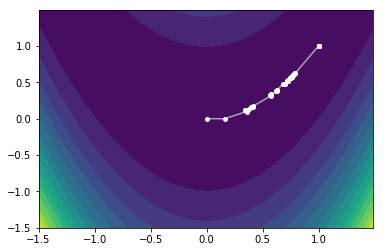

In [6]:
from cg_test import CallBack

def frosenbrock(z):
    """Rosenbrock function
    Parameters:
        z: nd_array, 2-D input value
    Returns:
        float"""
    x,y = z
    return (1-x)**2 + 100*(y- x**2)**2

callback=CallBack()
x0=np.zeros(2)

sol_nlcg = nlcg(frosenbrock,x0,callback=callback)j
print("Iterations: ", callback.getxk().shape[0])
#print("Iterates:\n", callback.getxk())
print("Test:\n", frosenbrock(sol_nlcg))
callback.plot(frosenbrock)

In [7]:
from cg_test import test

test(cg)
test(nlcg)


# Test cg on xQx+b.
Matrix Q

 [[0.5 1. ]
 [1.  5. ]]

Right hand side -b
 [-1. -1.]

Test (should be equal to -b):
Qx = [-1. -1.]

# Test nlcg on Rosenbrock function.
Test (should be 0):
 1.3201517317246784e-19
